In [2]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
importlib.reload(anomaly_detection)

/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'mhealth_anomaly_detection.anomaly_detection' from '/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/anomaly_detection.py'>

In [4]:
# Load ad results
EXPERIMENTS = [
    'exp01',
    #'exp02',
    #'exp03'
]
N_SUBJECTS = 100
DAYS_OF_DATA = 90

results_list = []
for exp in EXPERIMENTS:
    fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
    fpath = Path('../cache', fname)
    res = pd.read_csv(fpath)
    res['experiment'] = exp
    results_list.append(res)
data_df = pd.concat(results_list).fillna(-1)

anomaly_detector_cols = [d for d in data_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]

In [6]:
groupby_cols = [
    'subject_id',
    #'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]

In [7]:
performance_df = anomaly_detection.performance_metrics(
    data=data_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

print('Accuracy')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('F1')
print(performance_df.groupby('model').accuracy.describe().round(3))
print('Sensitivity')
print(performance_df.groupby('model').sensitivity.describe().round(3))
print('Specificity')
print(performance_df.groupby('model').specificity.describe().round(3))

100%|██████████| 2400/2400 [00:09<00:00, 242.72it/s]


Accuracy
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.711  0.144  0.389  0.578  0.756  0.822  0.956
NMF_003          2400.0  0.816  0.174  0.478  0.750  0.900  0.933  1.000
PCA_003          2400.0  0.823  0.176  0.489  0.761  0.911  0.944  1.000
RollingMean      2400.0  0.816  0.176  0.467  0.756  0.900  0.933  0.989
SVM_poly         2400.0  0.595  0.087  0.344  0.533  0.600  0.656  0.856
SVM_rbf          2400.0  0.746  0.156  0.367  0.611  0.800  0.867  0.967
SVM_sigmoid      2400.0  0.518  0.072  0.256  0.467  0.522  0.567  0.767
F1
                  count   mean    std    min    25%    50%    75%    max
model                                                                   
IsolationForest  2400.0  0.711  0.144  0.389  0.578  0.756  0.822  0.956
NMF_003          2400.0  0.816  0.174  0.478  0.750  0.900  0.933  1.000
PCA_003          2400.0  0.823  0.176  

In [8]:
performance_df.loc[performance_df.history_type == -1, 'history_type'] = 'history_all_28'
#performance_df.loc[performance_df.correlation_type == -1, 'corelation_type'] = 'Independent'

In [8]:

palette = lr.get_colors('../lib/colors.json')
model_order = [
    'RollingMean',
    'PCA_003',
    'NMF_003',
    'IsolationForest',
    'SVM_rbf',
    'SVM_poly',
    'SVM_sigmoid',
]
palette['model']

{'Linear Regression': '#718093',
 'Random Forest Regression': '#192a56',
 'Gradient Boosting Regression': '#487eb0',
 'Mixed Effects Random Forest': '#AF58BA',
 'Baseline': '#1A1A1A',
 'Logistic Regression': '#718093',
 'Random Forest Classifier': '#192a56',
 'Gradient Boosting Classifier': '#487eb0',
 'PCA': '#44AA99',
 'PCA_003': '#44AA99',
 'PCA_005': '#44AA99',
 'PCA_010': '#44AA99',
 'NMF': '#117733',
 'NMF_003': '#117733',
 'NMF_005': '#117733',
 'NMF_010': '#117733',
 'SVM': '#EE99AA',
 'SVM_rbf': '#EE99AA',
 'SVM_poly': '#994455',
 'SVM_sigmoid': '#882255',
 'IsolationForest': '#DDCC77',
 'RollingMean': '#88CCEE'}

<AxesSubplot: xlabel='metric', ylabel='Performance'>

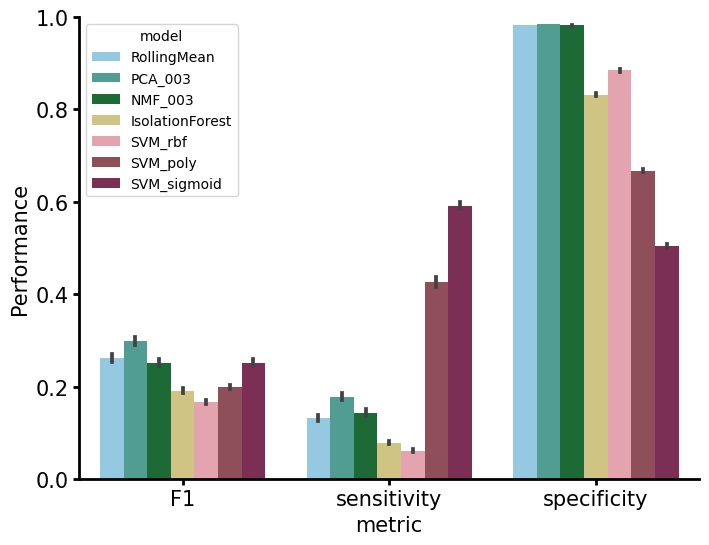

In [28]:
perf_melt = performance_df.melt(
    id_vars=groupby_cols + ['model'],
    value_vars=['F1', 'sensitivity', 'specificity'],
    var_name='metric',
    value_name='Performance'
)
perf_melt.loc[perf_melt.model == 'svm', 'model'] = 'SVM'
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(
    x='metric',
    y='Performance',
    hue='model',
    palette=palette['model'],
    hue_order=model_order,
    data=perf_melt,
    ax=ax
)
ax.set_ylim(0,1)
fa.despine_thicken_axes(ax, fontsize=15)

In [40]:
performance_df['anomaly_freq'].unique()

array([ 2,  7, 14, 28])

F1  sensitivity  specificity
model           history_type                                    
IsolationForest history_0_to_28  0.184        0.085        0.807
                history_all_28   0.199        0.073        0.857
NMF_003         history_0_to_28  0.245        0.140        0.982
                history_all_28   0.260        0.148        0.981
PCA_003         history_0_to_28  0.287        0.167        0.985
                history_all_28   0.310        0.190        0.985
RollingMean     history_0_to_28  0.261        0.133        0.984
                history_all_28   0.263        0.131        0.982
SVM_poly        history_0_to_28  0.204        0.416        0.691
                history_all_28   0.193        0.438        0.643
SVM_rbf         history_0_to_28  0.161        0.062        0.872
                history_all_28   0.173        0.061        0.897
SVM_sigmoid     history_0_to_28  0.246        0.584        0.491
                history_all_28   0.258        0.599        0.517

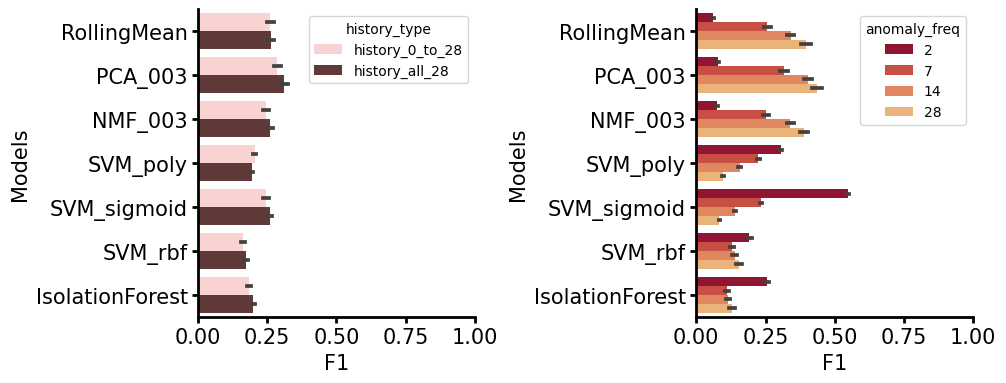

In [70]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2)
exp = 'exp01'
criteria = (
            (performance_df.experiment == exp)
)
palette['history_type'] = {
    'history_0_to_28': "#FFCCCC",
    'history_all_28': "#663333"
}
palette['anomaly_freq'] = {
    2: "#A50026",
    7: "#DD3D2D",
    14: "#F67E4B",
    28: "#FDB366"
}
metric = 'F1'
plt.subplots_adjust(wspace=.8)
for i, diff in enumerate(['history_type', 'anomaly_freq']):
    ax = axes[i]
    sns.barplot(
        y='model',
        x=metric,
        hue=diff,
        palette=palette[diff],
        data=performance_df[criteria],
        ax=ax
    )
    ax.set_xlim(0,1)
    #ax.legend().remove()
    ax.set_xlabel('F1')
    ax.set_ylabel('Models')
    fa.despine_thicken_axes(ax, fontsize=15)
performance_df[criteria].groupby(['model', 'history_type'])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [20]:
N_SUBJECTS = 100
DAYS_OF_DATA = 120

exp = 'exp02'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp2_df = pd.read_csv(fpath)
exp2_df['experiment'] = exp

In [21]:
exp2_df['n_features'].unique()
anomaly_detector_cols = [d for d in exp2_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'window_size',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance2_df = anomaly_detection.performance_metrics(
    data=exp2_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

100%|██████████| 500/500 [00:02<00:00, 172.47it/s]


In [22]:
performance2_df

,subject_id,window_size,n_features,anomaly_freq,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1
0,SID_0,14,5,28,exp02,RollingMean,3,112,4,1,0.75,0.428571,0.965517,0.958333,0.545455
1,SID_0,14,5,28,exp02,PCA_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636
2,SID_0,14,5,28,exp02,NMF_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636
3,SID_0,14,5,28,exp02,SVM_poly,3,67,49,1,0.75,0.057692,0.577586,0.583333,0.107143
4,SID_0,14,5,28,exp02,SVM_sigmoid,4,56,60,0,1.00,0.062500,0.482759,0.500000,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,SID_99,14,200,28,exp02,PCA_005,4,109,7,0,1.00,0.363636,0.939655,0.941667,0.533333
2996,SID_99,14,200,28,exp02,NMF_005,4,113,3,0,1.00,0.571429,0.974138,0.975000,0.727273
2997,SID_99,14,200,28,exp02,SVM_poly,4,72,44,0,1.00,0.083333,0.620690,0.633333,0.153846
2998,SID_99,14,200,28,exp02,SVM_sigmoid,4,19,97,0,1.00,0.039604,0.163793,0.191667,0.076190


/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iE

F1  sensitivity  specificity
model       n_features                                 
NMF_005     5           0.314        0.318        0.963
            10          0.392        0.400        0.967
            25          0.490        0.588        0.968
            100         0.666        0.880        0.972
            200         0.711        0.928        0.975
PCA_005     5           0.287        0.250        0.961
            10          0.491        0.572        0.973
            25          0.695        0.878        0.976
            100         0.665        0.958        0.967
            200         0.630        0.970        0.960
RollingMean 5           0.338        0.300        0.965
            10          0.395        0.392        0.970
            25          0.528        0.612        0.974
            100         0.771        0.935        0.982
            200         0.851        0.998        0.987
SVM_poly    5           0.101        0.710        0.571
            10          0.114        0.810        0.570
            25          0.125        0.865        0.584
            100         0.144        0.908        0.629
            200         0.154        0.952        0.638
SVM_rbf     5           0.142        0.015        0.906
            10            NaN        0.000        0.967
            25            NaN        0.000        0.998
            100         0.400        0.002        0.999
            200         0.400        0.002        0.999
SVM_sigmoid 5           0.085        0.715        0.478
            10          0.094        0.885        0.411
            25          0.092        0.982        0.328
            100         0.079        1.000        0.199
            200         0.076        1.000        0.156

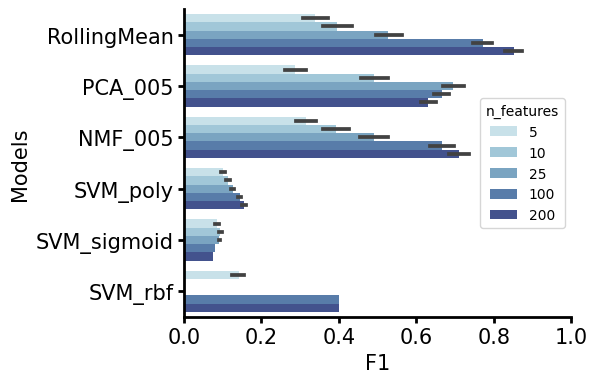

In [23]:
fig, ax = plt.subplots(figsize=(5,4))
subset = performance2_df[
    (performance2_df.window_size == 14) &
    (performance2_df.anomaly_freq == 28)
]
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    100: "#4a7BB7",
    200: "#364B9A"
}
metric = 'F1'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=subset,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
subset.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [19]:
subset[subset.model == 'SVM_rbf']

,subject_id,window_size,n_features,anomaly_freq,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1
143,SID_0,14,5,28,exp02,SVM_rbf,0,76,11,3,0.000000,0.000000,0.873563,0.844444,NaN
167,SID_0,14,10,28,exp02,SVM_rbf,0,84,3,3,0.000000,0.000000,0.965517,0.933333,NaN
191,SID_0,14,25,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
215,SID_0,14,100,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
239,SID_0,14,200,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35783,SID_99,14,5,28,exp02,SVM_rbf,1,81,6,2,0.333333,0.142857,0.931034,0.911111,0.2
35807,SID_99,14,10,28,exp02,SVM_rbf,0,83,4,3,0.000000,0.000000,0.954023,0.922222,NaN
35831,SID_99,14,25,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN
35855,SID_99,14,100,28,exp02,SVM_rbf,0,87,0,3,0.000000,NaN,1.000000,0.966667,NaN


In [58]:
N_SUBJECTS = 100
DAYS_OF_DATA = 90

exp = 'exp03'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp3_df = pd.read_csv(fpath)
exp3_df['experiment'] = exp


In [59]:
anomaly_detector_cols = [d for d in exp3_df.columns if d.endswith("_anomaly")]
groupby_cols = [
    'subject_id',
    'window_size',
    'correlation_type',
    'n_features',
    'anomaly_freq',
    'experiment'
]
performance3_df = anomaly_detection.performance_metrics(
    data=exp3_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)

100%|██████████| 3600/3600 [00:14<00:00, 246.97it/s]


In [60]:
performance3_df.correlation_type.unique()

array(['Independent', 'Linear', 'Non-linear'], dtype=object)

F1  sensitivity  specificity
model       correlation_type                                 
NMF_005     Independent       0.333        0.219        0.986
            Linear            0.286        0.172        0.985
            Non-linear        0.267        0.159        0.983
PCA_005     Independent       0.522        0.420        0.992
            Linear            0.370        0.262        0.988
            Non-linear        0.361        0.264        0.986
RollingMean Independent       0.378        0.216        0.988
            Linear            0.279        0.143        0.983
            Non-linear        0.289        0.195        0.980
SVM_poly    Independent       0.177        0.428        0.698
            Linear            0.172        0.393        0.700
            Non-linear        0.217        0.523        0.625
SVM_rbf     Independent       0.090        0.004        0.990
            Linear            0.146        0.026        0.948
            Non-linear        0.138        0.031        0.923
SVM_sigmoid Independent       0.289        0.783        0.430
            Linear            0.264        0.630        0.496
            Non-linear        0.263        0.672        0.467

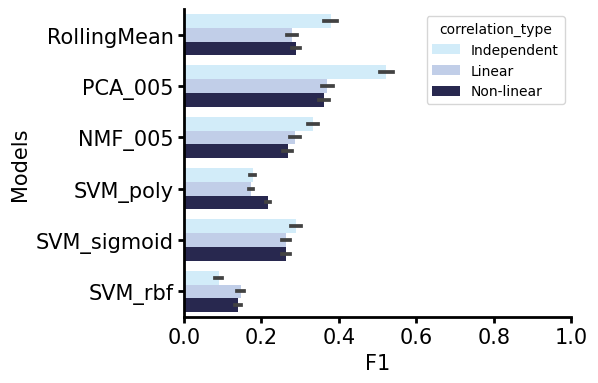

In [72]:
fig, ax = plt.subplots(figsize=(5,4))
palette['correlation_type'] = {
    'Independent': "#CCEEFF", 
    'Linear': "#BBCCEE", 
    'Non-linear': "#222255"
}
metric = 'F1'
diff = 'correlation_type'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance3_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance3_df.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)

In [24]:
N_SUBJECTS = 100
DAYS_OF_DATA = 120

exp = 'exp07'
fname = f'{exp}_nSubjects-{N_SUBJECTS}_nDays-{DAYS_OF_DATA}.csv'
fpath = Path('../cache', fname)
exp7_df = pd.read_csv(fpath)
exp7_df['experiment'] = exp


In [25]:

groupby_cols = [
    'subject_id',
    #'correlation_type',
    'window_size',
    'n_features',
    'anomaly_freq',
    'history_type',
    'experiment'
]
anomaly_detector_cols = [d for d in exp7_df.columns if d.endswith("_anomaly")]
performance7_df = anomaly_detection.performance_metrics(
    data=exp7_df,
    groupby_cols=groupby_cols,
    anomaly_detector_cols=anomaly_detector_cols,
)


100%|██████████| 600/600 [00:03<00:00, 188.76it/s]


In [26]:
performance7_df

,subject_id,window_size,n_features,anomaly_freq,history_type,experiment,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,precision,specificity,accuracy,F1
0,SID_0,14,5,28,history_all_28,exp07,RollingMean,3,112,4,1,0.75,0.428571,0.965517,0.958333,0.545455
1,SID_0,14,5,28,history_all_28,exp07,PCA_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636
2,SID_0,14,5,28,history_all_28,exp07,NMF_005,2,111,5,2,0.50,0.285714,0.956897,0.941667,0.363636
3,SID_0,14,5,28,history_all_28,exp07,SVM_poly,3,67,49,1,0.75,0.057692,0.577586,0.583333,0.107143
4,SID_0,14,5,28,history_all_28,exp07,SVM_sigmoid,4,56,60,0,1.00,0.062500,0.482759,0.500000,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,SID_99,14,500,28,history_all_28,exp07,PCA_005,0,111,5,4,0.00,0.000000,0.956897,0.925000,NaN
3596,SID_99,14,500,28,history_all_28,exp07,NMF_005,1,113,3,3,0.25,0.250000,0.974138,0.950000,0.250000
3597,SID_99,14,500,28,history_all_28,exp07,SVM_poly,4,66,50,0,1.00,0.074074,0.568966,0.583333,0.137931
3598,SID_99,14,500,28,history_all_28,exp07,SVM_sigmoid,4,17,99,0,1.00,0.038835,0.146552,0.175000,0.074766


/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZ

F1  sensitivity  specificity
model       n_features                                 
NMF_005     5           0.314        0.318        0.963
            10          0.229        0.105        0.957
            25          0.254        0.060        0.962
            50          0.258        0.050        0.968
            100         0.268        0.060        0.969
            500         0.259        0.062        0.969
PCA_005     5           0.287        0.250        0.961
            10          0.233        0.112        0.954
            25          0.279        0.058        0.968
            50          0.228        0.042        0.964
            100         0.221        0.052        0.960
            500         0.228        0.082        0.952
RollingMean 5           0.338        0.300        0.965
            10          0.216        0.072        0.956
            25          0.256        0.062        0.966
            50          0.275        0.055        0.972
            100         0.304        0.040        0.973
            500         0.280        0.022        0.978
SVM_poly    5           0.101        0.710        0.571
            10          0.076        0.550        0.546
            25          0.073        0.525        0.533
            50          0.082        0.575        0.551
            100         0.081        0.580        0.551
            500         0.077        0.598        0.511
SVM_rbf     5           0.142        0.015        0.906
            10          0.150        0.085        0.908
            25          0.400        0.002        0.994
            50            NaN        0.000        0.999
            100           NaN        0.000        0.999
            500         0.400        0.002        0.999
SVM_sigmoid 5           0.085        0.715        0.478
            10          0.077        0.620        0.475
            25          0.077        0.830        0.322
            50          0.075        0.902        0.234
            100         0.074        0.962        0.170
            500         0.074        0.998        0.135

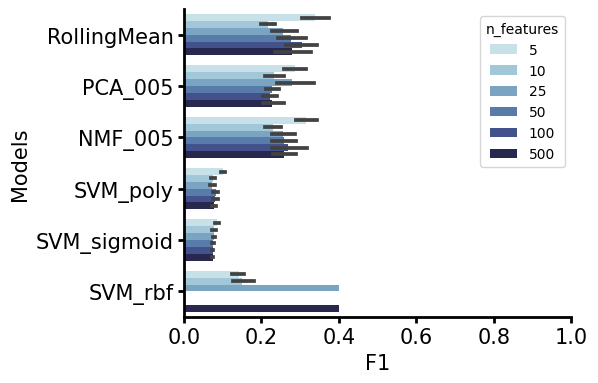

In [27]:

fig, ax = plt.subplots(figsize=(5,4))
palette['n_features'] = {
    5: "#C2E4EF",
    10: "#98CAE1",
    25: "#6EA6CD",
    50: "#4a7BB7",
    100: "#364B9A",
    500: "#222255",
}
metric = 'F1'
diff = 'n_features'
sns.barplot(
    y='model',
    x=metric,
    hue=diff,
    palette=palette[diff],
    data=performance7_df,
    ax=ax
)
ax.set_xlim(0,1)
#ax.legend().remove()
ax.set_ylabel('Models')
ax.set_xlabel(metric.capitalize())
fa.despine_thicken_axes(ax, fontsize=15)
performance7_df.groupby(['model', diff])[['F1', 'sensitivity', 'specificity']].mean().round(3)